# Notebook to train CNNs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id, clean_zone_identifier_files
from plotting_utils_torch import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from monai.networks.nets import ResNet
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

clean_zone_identifier_files("/home/diogommiranda/tese/")

/home/diogommiranda/tese/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-25 15:18:39.385304: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-25 15:18:41.784692: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


In [ ]:
NORMALIZATION = "mni_reg_CV" # Name of the directory with the datasets
DATASET = "smci_pmci_balanced" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 4 # Set batch size

USE_MASK = False # Set to True to use the ROI mask at the input-image level, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
else:
    ROI_MASK_PATH = None

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)

minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci_balanced/train...
    Found 349 files for class 'smci'
    Found 314 files for class 'pmci'
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci_balanced/test...
    Found 87 files for class 'smci'
    Found 78 files for class 'pmci'
Calculated Min: -0.3496308922767639, Max: 2.7912356853485107


torch.Size([1, 91, 109, 91])
Min value: 0.1018996462225914, Max value: 0.6943180561065674


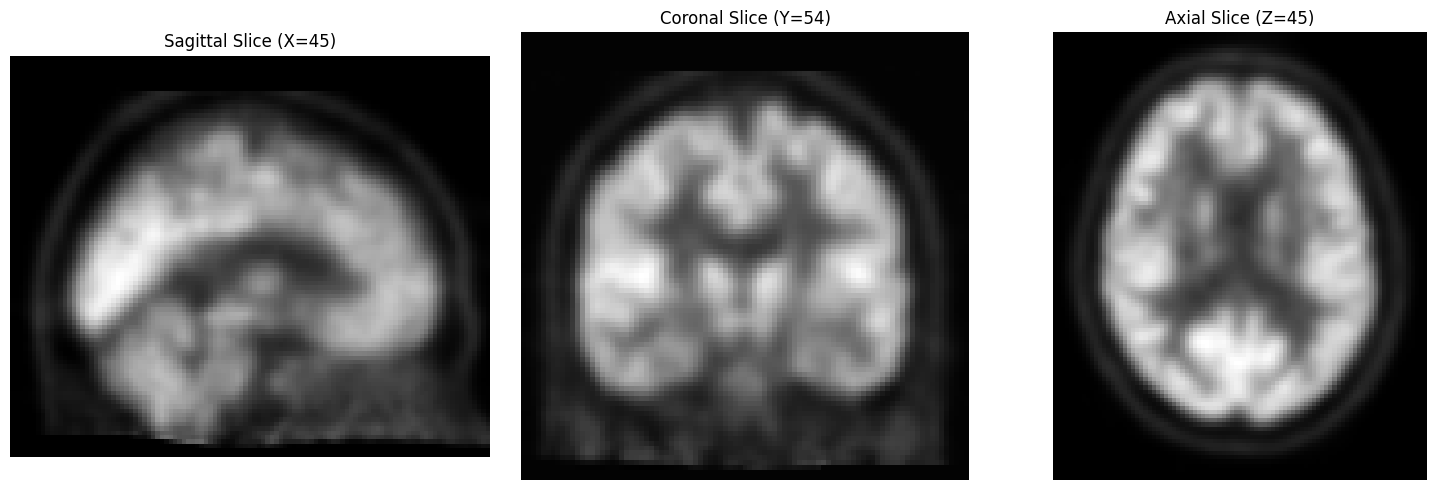

In [4]:
# Verify data with a test sample
i = 1
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    max_val = data[i].max()
    min_val = data[i].min()
    print(f"Min value: {min_val}, Max value: {max_val}")
    break

# Nested Cross-Validation

In [ ]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation
NUM_EPOCHS = 150
EARLY_STOP_PATIENCE = 30

learning_rates = [2e-7]
weight_decays = [2e-4]

RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/" + DATASET + "/" + str(BATCH_SIZE) + "B/"

os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

overall_start_time = time.time()

for current_lr in learning_rates:
    for current_wd in weight_decays: 
        print("=" * 60)
        print(f"Testing Combination: LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
        start_time_combination = time.time()

        #combo_dir_name = f"LR_{current_lr:.1e}_WD_{current_wd:.0e}"
        combo_dir_name = f"LR_{current_lr:.1e}_WD_{current_wd:.0e}_NESTED_CV"
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)

        if os.path.exists(combo_results_dir):
            print(f"\nDirectory {combo_results_dir} already exists. Skipping...\n")
            continue
        
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")
        print("=" * 60)

        current_combo_val_losses = []
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []
        
        current_combo_val_sensitivities = []
        current_combo_val_specificities = []
        current_combo_val_baccs = []
        current_combo_val_f1s = []
        current_combo_val_mccs = []

        current_combo_test_losses = []
        current_combo_test_accuracies = []
        current_combo_test_aucs = []
        
        current_combo_test_sensitivities = []
        current_combo_test_specificities = []
        current_combo_test_baccs = []
        current_combo_test_f1s = []
        current_combo_test_mccs = []

        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                    raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate intensity normalization parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            ) 
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )
            
            test_data = create_dataloader(
                paths=test_paths,
                labels=test_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False,
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
                )

            if fold_train_data is None or fold_val_data is None or test_data is None:
                    raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
                
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            # Create the model
            model = ResNet(
                block='basic',
                layers=[3, 4, 6, 3], # [3, 4, 6, 3] for ResNet34, [2, 2, 2, 2] for ResNet18
                block_inplanes=[64, 128, 256, 512],
                spatial_dims=3,
                n_input_channels=1,
                conv1_t_stride=2,
                num_classes=1,
                shortcut_type='B',
                bias_downsample = True
            )
            model.to(device)

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            optimizer = optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)

            best_val_loss = float('inf')
            best_val_bacc = -float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': [],
                               'val_sensitivity': [], 'val_specificity': [], 'val_bacc': [], 'val_f1': [], 'val_mcc': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # ---------------- Train phase ----------------
                model.train()
                
                running_loss = 0.0
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())

                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)

                # ---------------- Validation phase ----------------
                model.eval()
                val_running_loss = 0.0
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        val_running_loss += loss.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = val_running_loss / len(fold_val_data.dataset)
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                
                val_true = val_targets.astype(int)
                val_pred = val_pred_probs.round().astype(int)
                
                val_sensitivity = recall_score(val_true, val_pred, pos_label=1)
                val_specificity = recall_score(val_true, val_pred, pos_label=0)
                val_bacc = balanced_accuracy_score(val_true, val_pred)
                val_f1 = f1_score(val_true, val_pred, average='weighted')
                val_mcc = matthews_corrcoef(val_true, val_pred)
                
                
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)
                
                history['val_sensitivity'].append(val_sensitivity)
                history['val_specificity'].append(val_specificity)
                history['val_bacc'].append(val_bacc)
                history['val_f1'].append(val_f1)
                history['val_mcc'].append(val_mcc)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                #print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                #        f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                #        f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                

                # Early stopping check
                if DATASET == "smci_pmci_balanced":
                    # For smci_pmci_balanced, we monitor validation loss for early stopping (balanced dataset)
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        epochs_no_improve = 0
                        # Save the best model state
                        best_model_state = model.state_dict()
                        best_epoch = epoch + 1
                    else:
                        epochs_no_improve += 1
                elif DATASET == "smci_pmci":
                    # For smci_pmci, we monitor balanced accuracy for early stopping to deal with class imbalance
                    if val_bacc > best_val_bacc:
                        best_val_bacc = val_bacc
                        epochs_no_improve = 0
                        # Save the best model state
                        best_model_state = model.state_dict()
                        best_epoch = epoch + 1
                    else:
                        epochs_no_improve += 1
                else:
                    raise ValueError("Invalid dataset. Add option to the if statement.")

                if epochs_no_improve >= EARLY_STOP_PATIENCE:
                    model.load_state_dict(best_model_state)
                    print(f"\nEarly stopping triggered. Restoring best model weights from epoch {best_epoch}.\n")
                    break
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)

            best_epoch_index = best_epoch - 1
            
            val_loss_best = history['val_loss'][best_epoch_index]
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            
            val_sensitivity_best = history['val_sensitivity'][best_epoch_index]
            val_specificity_best = history['val_specificity'][best_epoch_index]
            val_bacc_best = history['val_bacc'][best_epoch_index]
            val_f1_best = history['val_f1'][best_epoch_index]
            val_mcc_best = history['val_mcc'][best_epoch_index]
            
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}, \n"
                    f"    Sensitivity: {val_sensitivity_best:.4f}, Specificity: {val_specificity_best:.4f}, BACC: {val_bacc_best:.4f}, F1: {val_f1_best:.4f}, MCC: {val_mcc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            current_combo_val_sensitivities.append(val_sensitivity_best)
            current_combo_val_specificities.append(val_specificity_best)
            current_combo_val_baccs.append(val_bacc_best)
            current_combo_val_f1s.append(val_f1_best)
            current_combo_val_mccs.append(val_mcc_best)
            
            optimizer_name = optimizer.__class__.__name__
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1
            
            # Save the validation metrics for current fold
            val_metrics_file_path = os.path.join(fold_dir, "val_results.txt")
            with open(val_metrics_file_path, "w") as f:
                f.write("--- Validation Metrics ---\n")
                f.write(f"Loss:        {val_loss_best:.4f}\n")
                f.write(f"Accuracy:    {val_accuracy_best:.4f}\n")
                f.write(f"Sensitivity: {val_sensitivity_best:.4f}\n")
                f.write(f"Specificity: {val_specificity_best:.4f}\n")
                f.write(f"Balanced Accuracy (BACC): {val_bacc_best:.4f}\n")
                f.write(f"F1 Score (Weighted):      {val_f1_best:.4f}\n")
                f.write(f"Matthews Corr Coef (MCC): {val_mcc_best:.4f}\n")
                f.write(f"Area Under the Curve (AUC): {val_auc_best:.4f}\n")
            
            # ---------------- Evaluate the model on the test data ---------------- 
            model.eval()
            test_running_loss = 0.0
            test_pred_probs = []
            test_targets = []

            with torch.inference_mode():
                for inputs, labels in test_data:
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)

                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    test_running_loss += loss.item() * inputs.size(0)
                
                    prob_outputs = torch.sigmoid(outputs)
                    
                    test_pred_probs.extend(prob_outputs.cpu().numpy())
                    test_targets.extend(labels.cpu().numpy())

            test_targets = np.array(test_targets).flatten()
            test_pred_probs = np.array(test_pred_probs).flatten()

            # Calculate test loss and accuracy
            test_loss = test_running_loss / len(test_data.dataset)
            test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)

            y_true = test_targets.astype(int)
            y_pred = test_pred_probs.round().astype(int)

            # Calculate metrics
            test_sensitivity = recall_score(y_true, y_pred, pos_label=1)
            test_specificity = recall_score(y_true, y_pred, pos_label=0)
            test_bacc = balanced_accuracy_score(y_true, y_pred)
            test_f1 = f1_score(y_true, y_pred, average='weighted')
            test_mcc = matthews_corrcoef(y_true, y_pred)
            test_auc_score = roc_auc_score(y_true, y_pred)
            
            print(f"    Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, AUC: {test_auc_score:.4f}, \n"
                  f"    Sensitivity: {test_sensitivity:.4f}, Specificity: {test_specificity:.4f}, BACC: {test_bacc:.4f}, F1: {test_f1:.4f}, MCC: {test_mcc:.4f}")
            
            classes = DATASET.split("_")
            class0, class1 = classes[0], classes[1]
            target_names = [class0, class1]

            # Save the confusion matrix plot
            make_confusion_matrix(y_true=y_true,
                                y_pred=y_pred.round(),
                                classes=target_names,
                                figsize=(8, 8),
                                text_size=15,
                                save_dir=fold_dir)

            # Save the test loss and accuracy and the evaluation metrics
            result_file_path = os.path.join(fold_dir, "test_results.txt")
            with open(result_file_path, "w") as f:
                f.write(f"[{test_loss}, {test_acc}]\n\n")
                f.write("--- Evaluation Metrics on Test Set ---\n")
                f.write(f"Accuracy:    {test_acc:.4f}\n")
                f.write(f"Sensitivity: {test_sensitivity:.4f}\n")
                f.write(f"Specificity: {test_specificity:.4f}\n")
                f.write(f"Balanced Accuracy (BACC): {test_bacc:.4f}\n")
                f.write(f"F1 Score (Weighted):      {test_f1:.4f}\n")
                f.write(f"Matthews Corr Coef (MCC): {test_mcc:.4f}\n")
                f.write(f"Area Under the Curve (AUC): {test_auc_score:.4f}\n")
                
            test_config = {
                "num_epochs": int(best_epoch),
                "optimizer": optimizer_name,
                "optimizer_params": {
                    "lr": float(current_lr),
                    "weight_decay": float(current_wd)
                },
                "batch_size": BATCH_SIZE,
                "seed": seed,
                "dataset": DATASET
            }
            params_file_path = os.path.join(fold_dir, "test_config.json")
            with open(params_file_path, "w") as f:
                json.dump(test_config, f, indent=4)
                    
            # Append results for this fold
            current_combo_test_losses.append(test_loss)
            current_combo_test_accuracies.append(test_acc)
            current_combo_test_aucs.append(test_auc_score)
            
            current_combo_test_sensitivities.append(test_sensitivity)
            current_combo_test_specificities.append(test_specificity)
            current_combo_test_baccs.append(test_bacc)
            current_combo_test_f1s.append(test_f1)
            current_combo_test_mccs.append(test_mcc)
            
            # Free resources
            del model, optimizer, criterion, fold_train_data, fold_val_data, history, history_df, best_model_state
            if device.type == 'cuda':
                torch.cuda.empty_cache() 
            gc.collect() 

        end_time_combination = time.time()
        print(f"Combination finished in {end_time_combination - start_time_combination:.2f} seconds.")

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)
        
        avg_sensitivity = np.mean(current_combo_val_sensitivities)
        avg_specificity = np.mean(current_combo_val_specificities)
        avg_bacc = np.mean(current_combo_val_baccs)
        std_bacc = np.std(current_combo_val_baccs)
        avg_f1 = np.mean(current_combo_val_f1s)
        std_f1 = np.std(current_combo_val_f1s)
        avg_mcc = np.mean(current_combo_val_mccs)

        combo_average_results = {
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch),
            'avg_val_sensitivity': avg_sensitivity,
            'avg_val_specificity': avg_specificity,
            'avg_val_bacc': avg_bacc,
            'std_val_bacc': std_bacc,
            'avg_val_f1': avg_f1,
            'std_val_f1': std_f1,
            'avg_val_mcc': avg_mcc,
            'individual_sensitivities': [round(sensitivity, 4) for sensitivity in current_combo_val_sensitivities],
            'individual_specificities': [round(specificity, 4) for specificity in current_combo_val_specificities],
            'individual_baccs': [round(bacc, 4) for bacc in current_combo_val_baccs],
            'individual_f1s': [round(f1, 4) for f1 in current_combo_val_f1s],
            'individual_mccs': [round(mcc, 4) for mcc in current_combo_val_mccs],
        }

        # Save results in a txt file and the parameters in a json file
        val_results_df = pd.DataFrame(combo_average_results)
        display_cols = list(combo_average_results.keys())

        val_results_filepath = os.path.join(combo_results_dir, "validation_results.txt")
        with open(val_results_filepath, "w") as f:
            print("Validation Results Summary:", file=f)
            print(val_results_df[display_cols].round(6).to_string(index=False, max_colwidth=None, line_width=250), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)

        avg_test_loss = np.mean(current_combo_test_losses)
        std_test_loss = np.std(current_combo_test_losses)
        avg_test_acc = np.mean(current_combo_test_accuracies)
        std_test_acc = np.std(current_combo_test_accuracies)
        avg_test_auc = np.mean(current_combo_test_aucs)
        std_test_auc = np.std(current_combo_test_aucs)
        
        avg_test_sensitivity = np.mean(current_combo_test_sensitivities)
        std_test_sensitivity = np.std(current_combo_test_sensitivities)
        avg_test_specificity = np.mean(current_combo_test_specificities)
        std_test_specificity = np.std(current_combo_test_specificities)
        avg_test_bacc = np.mean(current_combo_test_baccs)
        std_test_bacc = np.std(current_combo_test_baccs)
        avg_test_f1 = np.mean(current_combo_test_f1s)
        std_test_f1 = np.std(current_combo_test_f1s)
        avg_test_mcc = np.mean(current_combo_test_mccs)
        std_test_mcc = np.std(current_combo_test_mccs)

        combo_test_average_results = {
            'avg_test_loss': avg_test_loss,	
            'std_test_loss': std_test_loss,
            'avg_test_accuracy': avg_test_acc,
            'std_test_accuracy': std_test_acc,
            'avg_test_auc': avg_test_auc,
            'std_test_auc': std_test_auc,
            'individual_test_losses': [round(loss, 4) for loss in current_combo_test_losses],
            'individual_test_accuracies': [round(acc, 4) for acc in current_combo_test_accuracies],
            'individual_test_aucs': [round(auc, 4) for auc in current_combo_test_aucs],
            'avg_test_sensitivity': avg_test_sensitivity,
            'std_test_sensitivity': std_test_sensitivity,
            'avg_test_specificity': avg_test_specificity,
            'std_test_specificity': std_test_specificity,
            'avg_test_bacc': avg_test_bacc,
            'std_test_bacc': std_test_bacc,
            'avg_test_f1': avg_test_f1,
            'std_test_f1': std_test_f1,
            'avg_test_mcc': avg_test_mcc,
            'std_test_mcc': std_test_mcc,
            'individual_test_sensitivities': [round(sensitivity, 4) for sensitivity in current_combo_test_sensitivities],
            'individual_test_specificities': [round(specificity, 4) for specificity in current_combo_test_specificities],
            'individual_test_baccs': [round(bacc, 4) for bacc in current_combo_test_baccs],
            'individual_test_f1s': [round(f1, 4) for f1 in current_combo_test_f1s],
            'individual_test_mccs': [round(mcc, 4) for mcc in current_combo_test_mccs],
        }
            
        test_results_df = pd.DataFrame(combo_test_average_results)
        display_cols = list(combo_test_average_results.keys())
        test_results_filepath = os.path.join(combo_results_dir, "average_test_results.txt")
        with open(test_results_filepath, "w") as f:
            print("Test Results Summary:", file=f)
            print(test_results_df[display_cols].round(6).to_string(index=False, max_colwidth=None, line_width=250), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)

        training_config = {
            "num_folds": N_SPLITS,
            "num_epochs": NUM_EPOCHS,
            "early_stop_patience": EARLY_STOP_PATIENCE,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(current_lr),
                "weight_decay": float(current_wd)
            }, 
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(combo_results_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)

Results will be saved to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci_balanced/fixed_lr/16B/
Testing Combination: LR=2.0e-07, WeightDecay=2e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci_balanced/fixed_lr/16B/LR_2.0e-07_WD_2e-04_NESTED_CV
------------------------------------------------------------
Training Fold 1/5 for LR=2.0e-07 and WD=2e-04...
  Train samples: 513, Validation samples: 150
Using z-score normalization
Calculating mean and std for 513 files...
Processed 50/513 files (9.7%)
Processed 100/513 files (19.5%)
Processed 150/513 files (29.2%)
Processed 200/513 files (39.0%)
Processed 250/513 files (48.7%)
Processed 300/513 files (58.5%)
Processed 350/513 files (68.2%)
Processed 400/513 files (78.0%)
Processed 450/513 files (87.7%)
Processed 500/513 files (97.5%)
Calculated Mean: 0.2826048660769364, Std: 0.42233118432751776
  Fold train label counts: {0: 272, 1: 241}
  Calculated pos_weight for BCEWithLogitsL

100%|██████████| 150/150 [11:41<00:00,  4.68s/it]

Training completed for 150 epochs. Restoring best model weights from epoch 129.
    Fold 1 - Best Epoch 129, Val Loss: 0.3627, Acc: 0.8667, AUC: 0.9292, 
    Sensitivity: 0.8630, Specificity: 0.8701, BACC: 0.8666, F1: 0.8667, MCC: 0.7331
    Fold 1 finished in 872.42 seconds.


    Test Loss: 0.6873, Test Accuracy: 0.7636, AUC: 0.7560, 
    Sensitivity: 0.6154, Specificity: 0.8966, BACC: 0.7560, F1: 0.7580, MCC: 0.5375
------------------------------------------------------------
Training Fold 2/5 for LR=2.0e-07 and WD=2e-04...
  Train samples: 546, Validation samples: 117
Using z-score normalization
Calculating mean and std for 546 files...
Processed 50/546 files (9.2%)
Processed 100/546 files (18.3%)
Processed 150/546 files (27.5%)
Processed 200/546 files (36.6%)
Processed 250/546 files (45.8%)
Processed 300/546 files (54.9%)
Processed 350/546 files (64.1%)
Processed 400/546 files (73.3%)
Processed 450/546 files (82.4%)
Processed 500/546 files (91.6%)
Calculated Mean: 0.28388055405061335, Std: 0.422294840822519
  Fold train label counts: {0: 283, 1: 263}
  Calculated pos_weight for BCEWithLogitsLoss: 1.0760


 79%|███████▊  | 118/150 [10:17<02:47,  5.23s/it]


Early stopping triggered. Restoring best model weights from epoch 89.



    Fold 2 - Best Epoch 89, Val Loss: 0.3681, Acc: 0.8291, AUC: 0.9232, 
    Sensitivity: 0.7647, Specificity: 0.8788, BACC: 0.8217, F1: 0.8281, MCC: 0.6509
    Fold 2 finished in 806.68 seconds.
    Test Loss: 0.6430, Test Accuracy: 0.7697, AUC: 0.7637, 
    Sensitivity: 0.6538, Specificity: 0.8736, BACC: 0.7637, F1: 0.7662, MCC: 0.5437
------------------------------------------------------------
Training Fold 3/5 for LR=2.0e-07 and WD=2e-04...
  Train samples: 536, Validation samples: 127
Using z-score normalization
Calculating mean and std for 536 files...
Processed 50/536 files (9.3%)
Processed 100/536 files (18.7%)
Processed 150/536 files (28.0%)
Processed 200/536 files (37.3%)
Processed 250/536 files (46.6%)
Processed 300/536 files (56.0%)
Processed 350/536 files (65.3%)
Processed 400/536 files (74.6%)
Processed 450/536 files (84.0%)
Processed 500/536 files (93.3%)
Calculated Mean: 0.2839588862799364, Std: 0.4220739010470722
  Fold train label counts: {0: 279, 1: 257}
  Calculate

 59%|█████▉    | 89/150 [07:11<04:55,  4.84s/it]


Early stopping triggered. Restoring best model weights from epoch 60.

    Fold 3 - Best Epoch 60, Val Loss: 0.4849, Acc: 0.7795, AUC: 0.8674, 
    Sensitivity: 0.6667, Specificity: 0.8714, BACC: 0.7690, F1: 0.7763, MCC: 0.5543
    Fold 3 finished in 618.04 seconds.


    Test Loss: 0.5380, Test Accuracy: 0.8000, AUC: 0.7958, 
    Sensitivity: 0.7179, Specificity: 0.8736, BACC: 0.7958, F1: 0.7984, MCC: 0.6013
------------------------------------------------------------
Training Fold 4/5 for LR=2.0e-07 and WD=2e-04...
  Train samples: 517, Validation samples: 146
Using z-score normalization
Calculating mean and std for 517 files...
Processed 50/517 files (9.7%)
Processed 100/517 files (19.3%)
Processed 150/517 files (29.0%)
Processed 200/517 files (38.7%)
Processed 250/517 files (48.4%)
Processed 300/517 files (58.0%)
Processed 350/517 files (67.7%)
Processed 400/517 files (77.4%)
Processed 450/517 files (87.0%)
Processed 500/517 files (96.7%)
Calculated Mean: 0.28304148837755644, Std: 0.4220366656717802
  Fold train label counts: {0: 275, 1: 242}
  Calculated pos_weight for BCEWithLogitsLoss: 1.1364


 83%|████████▎ | 124/150 [09:50<02:03,  4.76s/it]


Early stopping triggered. Restoring best model weights from epoch 95.

    Fold 4 - Best Epoch 95, Val Loss: 0.4687, Acc: 0.8014, AUC: 0.8756, 
    Sensitivity: 0.7917, Specificity: 0.8108, BACC: 0.8012, F1: 0.8013, MCC: 0.6026
    Fold 4 finished in 765.45 seconds.


    Test Loss: 0.6643, Test Accuracy: 0.7455, AUC: 0.7354, 
    Sensitivity: 0.5513, Specificity: 0.9195, BACC: 0.7354, F1: 0.7353, MCC: 0.5115
------------------------------------------------------------
Training Fold 5/5 for LR=2.0e-07 and WD=2e-04...
  Train samples: 540, Validation samples: 123
Using z-score normalization
Calculating mean and std for 540 files...
Processed 50/540 files (9.3%)
Processed 100/540 files (18.5%)
Processed 150/540 files (27.8%)
Processed 200/540 files (37.0%)
Processed 250/540 files (46.3%)
Processed 300/540 files (55.6%)
Processed 350/540 files (64.8%)
Processed 400/540 files (74.1%)
Processed 450/540 files (83.3%)
Processed 500/540 files (92.6%)
Calculated Mean: 0.2836774783572901, Std: 0.4220434746699626
  Fold train label counts: {0: 287, 1: 253}
  Calculated pos_weight for BCEWithLogitsLoss: 1.1344


 72%|███████▏  | 108/150 [08:43<03:23,  4.85s/it]


Early stopping triggered. Restoring best model weights from epoch 79.

    Fold 5 - Best Epoch 79, Val Loss: 0.4961, Acc: 0.7967, AUC: 0.8654, 
    Sensitivity: 0.8033, Specificity: 0.7903, BACC: 0.7968, F1: 0.7967, MCC: 0.5936
    Fold 5 finished in 702.99 seconds.


    Test Loss: 0.6705, Test Accuracy: 0.7576, AUC: 0.7502, 
    Sensitivity: 0.6154, Specificity: 0.8851, BACC: 0.7502, F1: 0.7522, MCC: 0.5233
Combination finished in 3771.48 seconds.


# Train the model with the best hyperparameters and evaluate it on the test set

In [4]:
if ROI_MASK_PATH is None:
    print("\nUsing full brain scan.\n")
else:
    print("\nUsing ROI mask.\n")


Using full brain scan.



In [ ]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

# Hyperparameters
BEST_LR = 1e-5 # learning rate
BEST_WD= 2e-4 # weight decay
BEST_NUM_EPOCHS =  10 # number of epochs for training
train_for_more_epochs = False
loading = False

# Filepath to save/load the model
SAVED_MODEL_FILEPATH = "/home/diogommiranda/tese/outputs/best_model.pth"

# Create the model
model = ResNet(
    block='basic',
    layers=[3, 4, 6, 3],
    block_inplanes=[64, 128, 256, 512],
    spatial_dims=3,
    n_input_channels=1,
    conv1_t_stride=2,
    num_classes=1,
    shortcut_type='B',
    bias_downsample=True
)
model.to(device)

# Load saved model or train anew
if train_for_more_epochs:
    model.load_state_dict(torch.load(SAVED_MODEL_FILEPATH, weights_only=True, map_location=device)) # load model to continue training for more epochs
    print(f"\nLoading model weights to continue training for more epochs.")
else:
    print(f"\nTraining the model from scratch.")

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD)

# Save optimizer name to use in the saving files
optimizer_name = optimizer.__class__.__name__

history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': []}

for epoch in tqdm(range(BEST_NUM_EPOCHS)):
    epoch_start_time = time.time()
    history['epoch'].append(epoch + 1)

    model.train()
    running_loss = 0.0
    train_pred_probs = []
    train_targets = []

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        
        prob_outputs = torch.sigmoid(outputs)
        train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

    train_targets = np.array(train_targets).flatten()
    train_pred_probs = np.array(train_pred_probs).flatten()
    
    # Calculate training metrics for the epoch
    train_loss = running_loss / len(train_data.dataset)
    train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
    train_auc = roc_auc_score(train_targets, train_pred_probs)
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['train_auc'].append(train_auc)
        
    epoch_duration = time.time() - epoch_start_time
    print(f"    Epoch {epoch+1}/{BEST_NUM_EPOCHS} [{epoch_duration:.2f}s] - Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")
    

# Save the model if using fixed learning rate in case we want to continue training it
if not loading:
    torch.save(model.state_dict(), SAVED_MODEL_FILEPATH)
    print(f"Model saved to: {SAVED_MODEL_FILEPATH}")

plot_loss_curves(history)

# Evaluate the model on the test data
model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")


Training the model from scratch.
  Train label counts: {0: 430, 1: 269}
  Calculated pos_weight for BCEWithLogitsLoss: 1.5985

Using SGD optimizer with LR=1.0e-05 and WD=2e-04.


  0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 


--- Evaluation Metrics on Test Set ---
Accuracy:    0.9194
Sensitivity: 0.9074
Specificity: 0.9286 
Balanced Accuracy (BACC): 0.9180
F1 Score (Weighted):      0.9194
Matthews Corr Coef (MCC): 0.8360
Area Under the Curve (AUC): 0.9180



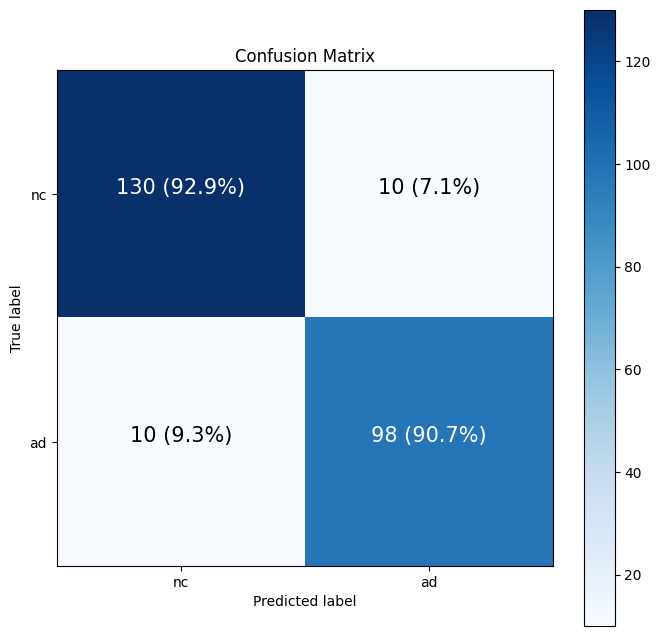

In [136]:
y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)


# Save the model

In [ ]:
save_option = False # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
        
    save_model_dir = "/home/diogommiranda/tese/outputs/torch/full_brain/" + DATASET + "/saved_models/" + str(BATCH_SIZE) + "B" + f"/LR={BEST_LR:.1e}_WD={BEST_WD:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), os.path.join(save_model_dir, "model.pth"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"[{test_loss}, {test_acc}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")
        
    training_config = {
        "num_epochs": BEST_NUM_EPOCHS,
        "optimizer": optimizer_name,
        "optimizer_params": {
            "lr": float(BEST_LR),
            "weight_decay": float(BEST_WD)
        },
        "batch_size": BATCH_SIZE,
        "seed": seed,
        "dataset": DATASET
    }
    params_file_path = os.path.join(save_model_dir, "training_config.json")
    with open(params_file_path, "w") as f:
        json.dump(training_config, f, indent=4)

Saving model to: /home/diogommiranda/tese/outputs/torch/full_brain/nc_ad/fixed_lr/saved_models/16B/LR=1.0e-05_WD=2e-04


# Load a model and try it

In [149]:
load_model = ResNet(
        block='basic',
        layers=[3, 4, 6, 3],
        block_inplanes=[64, 128, 256, 512],
        spatial_dims=3,
        n_input_channels=1,
        conv1_t_stride=2,
        num_classes=1,
        shortcut_type='B',
        bias_downsample=False
        )
load_model.to(device)

# Specify the path to the saved model
save_model_dir = None

load_model.load_state_dict(torch.load(os.path.join(save_model_dir, "model.pth"), map_location=device))

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

# Evaluate the model on the test data
load_model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = load_model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)


TypeError: expected str, bytes or os.PathLike object, not NoneType